![ex_screenshot](fd_path.png)

In [81]:
import os
import random
import numpy as np
from PIL import Image
import torchvision.transforms.functional as F
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

diff = imsize[0]-imsize[1]
if diff >= 0:
    padding = (0,int(diff/2))
else:
    padding = (int(abs(diff)/2),0)
resolution = 90 # FontDiffusion
transform =  transforms.Compose([
    transforms.Pad(padding,fill=255),
    transforms.Resize((resolution, resolution), interpolation=transforms.InterpolationMode.BILINEAR), 
    transforms.ToTensor()
])

In [82]:
ip = 'data/r40202/pngs/apple__AppleMyungjo__0.png'

In [83]:
content_image = Image.open(ip)

In [84]:
imsize = content_image.size

In [85]:
imsize

(233, 238)

In [86]:
transform(content_image).shape

torch.Size([1, 90, 90])

In [87]:
transform(content_image).shape

torch.Size([1, 90, 90])

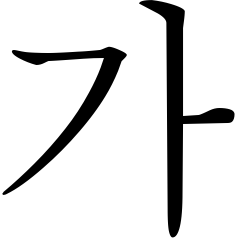

In [80]:
transform(content_image)

In [ ]:

class FontDataset(Dataset):
    """The dataset of font generation  
    """
    def __init__(self, args, phase, transforms=None, scr=False):
        super().__init__()
        self.root = args.data_root
        self.phase = phase
        
        # Get Data path
        self.get_path()
        self.transforms = transforms
        self.nonorm_transforms = get_nonorm_transform(args.resolution)

    def get_path(self):
        self.target_images = []
        # images with related style  
        self.style_to_images = {}
        target_image_dir = f"{self.root}/{self.phase}/TargetImage"
        for style in os.listdir(target_image_dir):
            images_related_style = []
            for img in os.listdir(f"{target_image_dir}/{style}"):
                img_path = f"{target_image_dir}/{style}/{img}"
                self.target_images.append(img_path)
                images_related_style.append(img_path)
            self.style_to_images[style] = images_related_style

    def __getitem__(self, index):
        target_image_path = self.target_images[index]
        target_image_name = target_image_path.split('/')[-1]
        style, content = target_image_name.split('.')[0].split('+')
        
        # Read content image
        content_image_path = f"{self.root}/{self.phase}/ContentImage/{content}.jpg"
        content_image = Image.open(content_image_path).convert('RGB')

        # Random sample used for style image
        images_related_style = self.style_to_images[style].copy()
        images_related_style.remove(target_image_path)
        style_image_path = random.choice(images_related_style)
        style_image = Image.open(style_image_path).convert("RGB")
        
        # Read target image
        target_image = Image.open(target_image_path).convert("RGB")
        nonorm_target_image = self.nonorm_transforms(target_image)

        if self.transforms is not None:
            content_image = self.transforms[0](content_image)
            style_image = self.transforms[1](style_image)
            target_image = self.transforms[2](target_image)
        
        sample = {
            "content_image": content_image,
            "style_image": style_image,
            "target_image": target_image,
            "target_image_path": target_image_path,
            "nonorm_target_image": nonorm_target_image}
        
        if self.scr:
            # Get neg image from the different style of the same content
            style_list = list(self.style_to_images.keys())
            style_index = style_list.index(style)
            style_list.pop(style_index)
            choose_neg_names = []
            for i in range(self.num_neg):
                choose_style = random.choice(style_list)
                choose_index = style_list.index(choose_style)
                style_list.pop(choose_index)
                choose_neg_name = f"{self.root}/train/TargetImage/{choose_style}/{choose_style}+{content}.jpg"
                choose_neg_names.append(choose_neg_name)

            # Load neg_images
            for i, neg_name in enumerate(choose_neg_names):
                neg_image = Image.open(neg_name).convert("RGB")
                if self.transforms is not None:
                    neg_image = self.transforms[2](neg_image)
                if i == 0:
                    neg_images = neg_image[None, :, :, :]
                else:
                    neg_images = torch.cat([neg_images, neg_image[None, :, :, :]], dim=0)
            sample["neg_images"] = neg_images

        return sample

    def __len__(self):
        return len(self.target_images)